## Data Analysis 3: Prediction and Introduction to Machine Learning
## Assignment 2

### Finding fast growing firms 2025: Preparation Notebook

#### prepared by Alina Imanakhunova and Sabira Onbayeva

In [ ]:
# Environment setup

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

In [2]:
from pathlib import Path

PROJECT_DIR = Path.cwd()                
DATA_DIR = PROJECT_DIR / "data"
OUTPUT_DIR = PROJECT_DIR / "outputs"
OUTPUT_DIR.mkdir(exist_ok=True)

RAW_PATH = DATA_DIR / "cs_bisnode_panel.csv"

## Data Preparation 

In [ ]:
# Load the raw dataset

data = pd.read_csv(RAW_PATH)
print("Raw shape:", data.shape)
data.head()

Raw shape: (287829, 48)


,comp_id,begin,end,COGS,amort,curr_assets,curr_liab,extra_exp,extra_inc,extra_profit_loss,...,gender,origin,nace_main,ind2,ind,urban_m,region_m,founded_date,exit_date,labor_avg
0,1001034.0,2005-01-01,2005-12-31,NaN,692.592590,7266.666504,7574.074219,0.0,0.0,0.0,...,mix,Domestic,5630.0,56.0,3.0,1,Central,1990-11-19,NaN,NaN
1,1001034.0,2006-01-01,2006-12-31,NaN,603.703674,13122.222656,12211.111328,0.0,0.0,0.0,...,mix,Domestic,5630.0,56.0,3.0,1,Central,1990-11-19,NaN,NaN
2,1001034.0,2007-01-01,2007-12-31,NaN,425.925934,8196.295898,7800.000000,0.0,0.0,0.0,...,mix,Domestic,5630.0,56.0,3.0,1,Central,1990-11-19,NaN,NaN
3,1001034.0,2008-01-01,2008-12-31,NaN,300.000000,8485.185547,7781.481445,0.0,0.0,0.0,...,mix,Domestic,5630.0,56.0,3.0,1,Central,1990-11-19,NaN,NaN
4,1001034.0,2009-01-01,2009-12-31,NaN,207.407410,5137.037109,15300.000000,0.0,0.0,0.0,...,mix,Domestic,5630.0,56.0,3.0,1,Central,1990-11-19,NaN,0.083333


In [ ]:
# Select data from years 2010 to 2015

data = data.query("year >= 2010 and year <= 2015").copy()
print("2010–2015 shape:", data.shape)
data["year"].value_counts().sort_index()

2010–2015 shape: (167606, 48)


year
2010    26784
2011    28222
2012    28469
2013    28474
2014    28151
2015    27506
Name: count, dtype: int64

In [ ]:
# Display the number of missing values in each column

data.isna().sum()

comp_id                      0
begin                        0
end                          0
COGS                    158556
amort                     4117
curr_assets                 57
curr_liab                   57
extra_exp                 3751
extra_inc                 3751
extra_profit_loss         3755
finished_prod           158855
fixed_assets                57
inc_bef_tax               3742
intang_assets               57
inventories                 57
liq_assets                  57
material_exp              4117
net_dom_sales           158556
net_exp_sales           158556
personnel_exp             4117
profit_loss_year            67
sales                     3742
share_eq                    57
subscribed_cap              57
tang_assets                 57
wages                   158707
D                       167606
balsheet_flag                0
balsheet_length              0
balsheet_notfullyear         0
year                         0
founded_year             18409
exit_yea

In [ ]:
# Drop columns with very high missingness (>80%)

miss_share = data.isna().mean()
drop_cols = miss_share[miss_share > 0.80].index.tolist()
data = data.drop(columns=drop_cols)
print("Dropped high-missing columns:", drop_cols)

Dropped high-missing columns: ['COGS', 'finished_prod', 'net_dom_sales', 'net_exp_sales', 'wages', 'D', 'exit_year', 'exit_date']


In [ ]:
# Ensure comp_id is clean before panel completion

data["comp_id"] = pd.to_numeric(data["comp_id"], errors="coerce")
data = data.dropna(subset=["comp_id"])
data["comp_id"] = data["comp_id"].astype(int)

In [8]:
# Add all missing (year, comp_id) combinations:
# Missing combinations will have NaNs in all other columns
data = (
    data.set_index(["year", "comp_id"])
        .unstack(fill_value="__MISSING__")
        .stack()
        .reset_index()
        .replace("__MISSING__", np.nan)
)

print("After completing panel:", data.shape)


After completing panel: (236250, 40)


In [9]:
data.dtypes
# We see that 'sales' and other numerical variables have 'object' type

year                     int64
comp_id                  int64
begin                      str
end                        str
amort                   object
curr_assets             object
curr_liab               object
extra_exp               object
extra_inc               object
extra_profit_loss       object
fixed_assets            object
inc_bef_tax             object
intang_assets           object
inventories             object
liq_assets              object
material_exp            object
personnel_exp           object
profit_loss_year        object
sales                   object
share_eq                object
subscribed_cap          object
tang_assets             object
balsheet_flag           object
balsheet_length         object
balsheet_notfullyear    object
founded_year            object
ceo_count               object
foreign                 object
female                  object
birth_year              object
inoffice_days           object
gender                     str
origin  

In [ ]:
# Variable Type Conversion

NUMERIC_COLS = [
    "sales",
    "curr_assets",
    "curr_liab",
    "fixed_assets",
    "intang_assets",
    "inventories",
    "liq_assets",
    "inc_bef_tax",
    "profit_loss_year",
    "material_exp",
    "personnel_exp",
    "share_eq",
    "subscribed_cap",
    "tang_assets",
    "labor_avg",
    "ceo_count",
    "female",
    "foreign",
    "birth_year",
    "inoffice_days",
    "ind2",
    "ind",
    "urban_m",
]

for col in NUMERIC_COLS:
    if col in data.columns:
        data[col] = pd.to_numeric(data[col], errors="coerce")

data["founded_year"] = pd.to_numeric(data["founded_year"], errors="coerce")

In [11]:
FLAG_COLS = ["balsheet_flag", "balsheet_notfullyear"]

for col in FLAG_COLS:
    if col in data.columns:
        data[col] = pd.to_numeric(data[col], errors="coerce")


In [12]:
# Remove economically impossible negative sales
data.loc[data["sales"] < 0, "sales"] = np.nan

# Sales in millions
data["sales_mil"] = data["sales"] / 1_000_000

# Log sales
data["ln_sales_mil"] = np.log(data["sales_mil"])
data.loc[data["sales_mil"] <= 0, "ln_sales_mil"] = np.nan

In [ ]:
# Sort panel (required for shift)
data = data.sort_values(["comp_id", "year"]).copy()

## Target design (2014 vs 2012)

In [14]:
BASE_YEAR = 2012
HORIZON = 2   # 2-year growth (2012 -> 2014)

data = data.sort_values(["comp_id", "year"]).copy()

# Sales H years ahead
data["ln_sales_future"] = data.groupby("comp_id")["ln_sales_mil"].shift(-HORIZON)

# Keep only base-year observations
base = data.loc[data["year"] == BASE_YEAR].copy()

# Compute growth
base["growth_ln_sales"] = base["ln_sales_future"] - base["ln_sales_mil"]

# Keep firms with valid growth
base = base.loc[base["growth_ln_sales"].notna()].copy()

print("Eligible firms:", base.shape[0])
base["growth_ln_sales"].describe()

Eligible firms: 17927


count    17927.000000
mean         0.136373
std          1.212031
min        -10.777810
25%         -0.216379
50%          0.118732
75%          0.472222
max         11.830921
Name: growth_ln_sales, dtype: float64

In [ ]:
# Winsorize growth to reduce extreme outliers 

lo, hi = base["growth_ln_sales"].quantile([0.01, 0.99])
base["growth_ln_sales"] = base["growth_ln_sales"].clip(lo, hi)

In [ ]:
# Convert Growth into Binary Target
# Fast growth is defined as firms in the top 20% of log sales growth over a two-year horizon (2012–2014).

TOP_PERCENTILE = 0.20

cutoff = base["growth_ln_sales"].quantile(1 - TOP_PERCENTILE)

base["fast_growth"] = (base["growth_ln_sales"] >= cutoff).astype(int)

print("Fast-growth share:", base["fast_growth"].mean())


Fast-growth share: 0.20003346906900207


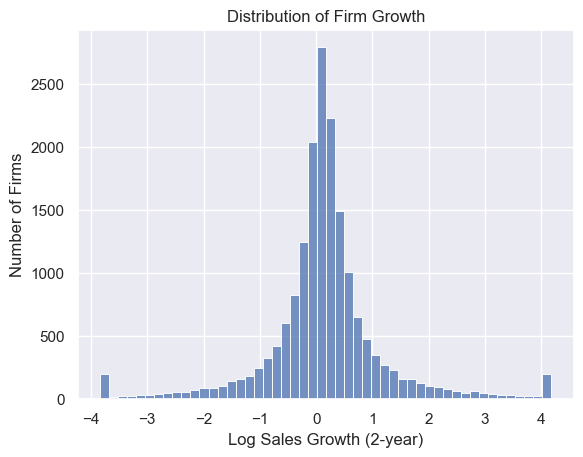

In [29]:
# Distribution of Firm Growth

sns.histplot(base["growth_ln_sales"], bins=50)

plt.xlabel("Log Sales Growth (2-year)")
plt.ylabel("Number of Firms")
plt.title("Distribution of Firm Growth")

plt.show()

The histogram above shows the distribution of log sales growth over the two-year horizon.

Most firms exhibit moderate growth around zero, indicating stable performance. However, the distribution displays heavy tails, suggesting that a subset of firms experiences exceptionally high or low growth rates.

## Feature engineering decisions

In [ ]:
# Industry grouping

base["ind2_cat"] = base["ind2"].copy()
base["ind2_cat"] = np.where(base["ind2_cat"] > 56, 60, base["ind2_cat"])
base["ind2_cat"] = np.where(base["ind2_cat"] < 26, 20, base["ind2_cat"])
base["ind2_cat"] = np.where(
    (base["ind2_cat"] < 55) & (base["ind2_cat"] > 35), 40, base["ind2_cat"]
)
base["ind2_cat"] = np.where(base["ind2_cat"] == 31, 30, base["ind2_cat"])
base["ind2_cat"] = np.where(base["ind2_cat"].isna(), 99, base["ind2_cat"])
base["ind2_cat"] = base["ind2_cat"].astype("category")

In [ ]:
# Task 2 grouping: manufacturing vs services (plus "other")

base["sector"] = np.where(
    base["ind2_cat"].astype(int) == 20, "manufacturing",
    np.where(base["ind2_cat"].astype(int) == 60, "services", "other")
)
base["sector"] = base["sector"].astype("category")

In [ ]:
# Controls as categories 

if "region_m" in base.columns:
    base["region_m"] = base["region_m"].astype("category")
if "urban_m" in base.columns:
    base["urban_m"] = base["urban_m"].astype("category")

In [ ]:
# Firm age (and square)

base["age"] = base["year"] - base["founded_year"]
base.loc[base["age"] < 0, "age"] = 0
base["age2"] = base["age"] ** 2

In [ ]:
# CEO variables 

base["ceo_age"] = base["year"] - base["birth_year"]
base.loc[(base["ceo_age"] < 18) | (base["ceo_age"] > 90), "ceo_age"] = np.nan

base["foreign_management"] = np.where(
    base["foreign"] >= 0.5, 1, np.where(base["foreign"].isna(), np.nan, 0)
)

base["gender_m"] = np.where(
    base["gender"].eq("male"), 1, np.where(base["gender"].isna(), np.nan, 0)
)

In [ ]:
# Total assets and core ratios (finance-relevant) 
# Clean negative items that should not be negative

for c in ["intang_assets", "curr_assets", "fixed_assets"]:
    if c in base.columns:
        base.loc[base[c] < 0, c] = np.nan

base["total_assets"] = base["intang_assets"] + base["curr_assets"] + base["fixed_assets"]
base.loc[base["total_assets"] <= 0, "total_assets"] = np.nan
base.loc[base["sales"] <= 0, "sales"] = np.nan

# Balance sheet ratios

base["liq_assets_bs"] = base["liq_assets"] / base["total_assets"]
base["curr_assets_bs"] = base["curr_assets"] / base["total_assets"]
base["fixed_assets_bs"] = base["fixed_assets"] / base["total_assets"]
base["intang_assets_bs"] = base["intang_assets"] / base["total_assets"]
base["share_eq_bs"] = base["share_eq"] / base["total_assets"]


In [ ]:
# Profit & loss ratios

base["profit_loss_year_pl"] = base["profit_loss_year"] / base["sales"]
base["inc_bef_tax_pl"] = base["inc_bef_tax"] / base["sales"]

# Replace inf with NaN

ratio_cols = [
    "liq_assets_bs", "curr_assets_bs", "fixed_assets_bs", "intang_assets_bs", "share_eq_bs",
    "profit_loss_year_pl", "inc_bef_tax_pl",
]
base[ratio_cols] = base[ratio_cols].replace([np.inf, -np.inf], np.nan)

In [ ]:
# Winsorize ratios (1% tails) 

def winsorize(s, p=0.01):
    s = s.copy()
    lo, hi = s.quantile([p, 1 - p])
    return s.clip(lo, hi)

for c in ratio_cols:
    base[c] = winsorize(base[c], p=0.01)

In [ ]:
# Squared terms 

base["ln_sales_mil_sq"] = base["ln_sales_mil"] ** 2
base["profit_loss_year_pl_sq"] = base["profit_loss_year_pl"] ** 2

In [ ]:
# Imputation + missing flags (good for logit; RF can handle too)

to_impute = [
    "ceo_age",
    "liq_assets_bs", "curr_assets_bs", "fixed_assets_bs", "intang_assets_bs", "share_eq_bs",
    "profit_loss_year_pl", "profit_loss_year_pl_sq", "inc_bef_tax_pl",
]

for c in to_impute:
    base[f"flag_miss_{c}"] = base[c].isna().astype(int)
    base[c] = base[c].fillna(base[c].median())

for c in ["foreign_management", "gender_m"]:
    base[f"flag_miss_{c}"] = base[c].isna().astype(int)
    base[c] = base[c].fillna(0)

print("Feature engineering done. Shape:", base.shape)

Feature engineering done. Shape: (17927, 73)


In [ ]:
# Export Clean Modelling Dataset

OUTPUT_PATH = "data/bisnode_firms_clean_growth.csv"

base.to_csv(OUTPUT_PATH, index=False)

print("Saved clean modeling dataset.")
print("Final shape:", base.shape)

Saved clean modeling dataset.
Final shape: (17927, 73)


## Summary of Data Preparation

The dataset was cleaned and transformed through:

• Panel completion  
• Financial ratio construction  
• Firm demographic variable engineering  
• Management characteristic creation  
• Target variable design based on future growth  

The resulting dataset is ready for predictive modelling (`predicting_fast_growth_firm.ipynb`)
